# Tools in LangGraph

Ok, so far we've covered the basics in LangGraph, we've learn the basics of working with `nodes`, `edges`, 
`states` and so on.

However, the examples we've used so far only involved simple Python functions or easy llm calls using the 
`.invoke` method from langchain. What if we want to be able to have a model use a tool (external functionality of some sort)
to be able to perform actions?

We start by initializing a model and connecting this model to a tool using basic langchain code:

In [ ]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

In [1]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

llm.invoke("Hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-ce20f206-e9b8-496a-889d-91a7f796972c-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [3]:
def sum_2_numbers(a: int, b: int)-> int:
    return a + b

math_tools = [sum_2_numbers]

llm_with_tools = llm.bind_tools(math_tools)

output = llm_with_tools.invoke("What is the sum of 10 + 23?")
output

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bvaIfmB3kO6M5tS4icXoldP6', 'function': {'arguments': '{"a":10,"b":23}', 'name': 'sum_2_numbers'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 54, 'total_tokens': 75, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-75e02208-c501-4760-b59e-c5f70d3fe509-0', tool_calls=[{'name': 'sum_2_numbers', 'args': {'a': 10, 'b': 23}, 'id': 'call_bvaIfmB3kO6M5tS4icXoldP6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 54, 'output_tokens': 21, 'total_tokens': 75, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning':

When we give the model access to a python function that can sum 2 numbers, what the model can now if called is to generate the appropriate
'call' to that function providing the right arguments. In the case of a simple request like "What is the sum of 10 + 23?",
the model knows that the arguments for the function will be: `10` and `23`.

However the output of the model is not an execution of that function, but instead this:

In [6]:
output.tool_calls

[{'name': 'sum_2_numbers',
  'args': {'a': 10, 'b': 23},
  'id': 'call_bvaIfmB3kO6M5tS4icXoldP6',
  'type': 'tool_call'}]

In this output we have the information needed to call the function:

In [8]:
tool_map = {
    'sum_2_numbers': sum_2_numbers
}
func = tool_map[output.tool_calls[0]['name']]
a = output.tool_calls[0]['args']['a']
b = output.tool_calls[0]['args']['b']
func(a,b)

33

That's great! What if we want this functionality into a LangGraph graph?

Simple! We can create a special node to handle these tool calls!

LangGraph makes that super easy by providing us with something called a [`ToolNode`](https://arc.net/l/quote/oskkgoji) which can take care of executing
the tool given the tool call output from an llm binded with that tool.

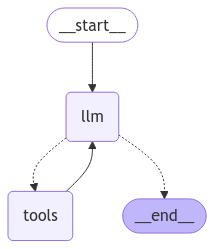

In [16]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image

def sum_2_numbers(a: int, b: int)->int:
    """
    Takes 2 arguments and returns their sum
    """
    return a + b


# Create our tool node
tool_node = ToolNode([sum_2_numbers])

# Create the graph
workflow = StateGraph(MessagesState)

# Add the LLM node that will generate tool calls
def llm_node(state: MessagesState) -> MessagesState:
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [*messages, response]}

# Add nodes and edges
workflow.add_node("llm", llm_node)
workflow.add_node("tools", tool_node)

# Add edges
workflow.add_edge(START, "llm")
workflow.add_conditional_edges("llm", tools_condition)
workflow.add_edge("tools", "llm")

# Compile the graph
graph = workflow.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


Notice that, instead of writing a routing function that encodes the logic for sending input to the ToolNode in case a tool call is made by the LLM
what happens is that we use `tools_condition` to not have to explicitly write that (given that we use this a lot).

In [19]:
graph.invoke({"messages": ["Sum of 10 and 4?"]})

{'messages': [HumanMessage(content='Sum of 10 and 4?', additional_kwargs={}, response_metadata={}, id='018a460e-acff-41d3-a4f6-86e92dcee700'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6xFBMYP5rMaDTrU10g7xJZAQ', 'function': {'arguments': '{"a":10,"b":4}', 'name': 'sum_2_numbers'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 51, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-17081a88-e0e5-4d1b-b975-31b6017f04db-0', tool_calls=[{'name': 'sum_2_numbers', 'args': {'a': 10, 'b': 4}, 'id': 'call_6xFBMYP5rMaDTrU10g7xJZAQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, '